In [15]:
import matplotlib.pyplot as plt
import seaborn
import random
import networkx as nx
import scipy.special
import numpy as np
%matplotlib inline

Define functions for SIR process

In [2]:
def recover(i_nodes, r_nodes, p_ir):
    """ Input: list of infected nodes, recovered nodes, and IR transition probability.
    Recovers some infected nodes at random according to p
    Output: list of infected nodes and recovered nodes """
    no_infected = len(i_nodes)
    if no_infected == 0:
        return i_nodes, r_nodes
    
    randoms = [random.random() for i in range(no_infected)]
    recover = [x<p_ir for x in randoms]
    I_array = np.asarray(i_nodes)
    filter = np.array(recover)
    new_recovered_nodes = list(I_array[filter]) # np array of infected nodes that are now recovered
    
    i_nodes = [item for item in i_nodes if item not in new_recovered_nodes]
    r_nodes += new_recovered_nodes
    
    return i_nodes, r_nodes 

def spread(G, s_nodes, i_nodes, p_si):
    """"Input: Networkx graph structure, list of s nodes, list of i nodes, and SI transition probability
    Each infected node will spread to each susceptible neighbor with probability p 
    Output: list of s nodes and i nodes 
    """
    
    for node_id in i_nodes:
        # find neighbors in the S state
        neighbors_in_s = list(set(G.neighbors(node_id)) & set(s_nodes))
        
        if len(neighbors_in_s) == 0: #If that node has no neighbors in S state, skip to next node
            continue
        
        randoms = [random.random() for i in range(len(neighbors_in_s))]
        infected = [x<p_si for x in randoms]
        filter = np.array(infected)
        neighbors_s_array = np.asarray(neighbors_in_s)
        
        new_infected_nodes = neighbors_s_array[filter] # np array of now-infected nodes
        new_infected_nodes = list(new_infected_nodes) # cast as list
        
        s_nodes = [item for item in s_nodes if item not in new_infected_nodes]
        
        i_nodes += new_infected_nodes
    
    return s_nodes, i_nodes

Define functions for node calculating its probability of disease, with no other information other than priors 

In [60]:
def prob_of_disease(G, node, p_vacc, p_si):
    """G: networkx graph
        node: node id for graph
        p_vacc: prior for vaccination probability
        p_si: infection probability """

    """Returns a node's probability of disease """
    
    p_infection = 0
    for i in range(G.degree(node)):
        p_infection+= scipy.special.binom(G.degree(node), i)*(p_vacc**i)*((1-p_vacc)**(G.degree(node)-i))*(1-((1-p_si)**(G.degree(node)-i)))
        
    return p_infection

def vaccinate_decision_making(G, thresholds, p_si, p_vacc):
    """Given information, some susceptible nodes decide to vaccinate """
    """Suppose we give information about how many first degree neighbors have vaccinated"""
    
    p_disease = [prob_of_disease(G, node, p_vacc, p_si) for node in G.nodes()]
#     print 'p disease', p_disease
    vaccinate = [p_disease[node] > thresholds[node] for node in G.nodes()]
    filter = np.array(vaccinate)
    v_nodes = list(np.asarray(G.nodes())[filter])
    return v_nodes

In [118]:
def simulate_main(G, p_si, p_ir, thresholds, p_vacc):
    '''Runs simulation''' 
    '''Terminates when all infected nodes have recovered'''
    
    v_nodes = vaccinate_decision_making(G, thresholds, p_si, p_vacc)
#     print 'vaccinated nodes:', v_nodes
    
    init_susceptible = list(set(G.nodes()) - set(v_nodes)) #Initially susceptible cannot be a vaccinated node
#     print 'init susceptible no:', len(init_susceptible)
    
    if len(init_susceptible) == 0:
        print 'none initially sucepble, all nodes decided to vaccinate'
        return [0], [0], [0], [len(v_nodes)], 1
    
    num_infected_init = np.int(len(init_susceptible)/5)
    
    # initialize nodes
    i_nodes = list(np.random.choice(init_susceptible, num_infected_init, replace=False)) # choose initially infected nodes. Cannot be an effectively vaccinated node.
    s_nodes = [node for node in init_susceptible if node not in i_nodes] # susceptible nodes are not infected and not vaccinatd
    r_nodes = [] # recovered AFTER getting infection 
    
    # initialize lengths
    num_s_nodes = [len(s_nodes)]
    num_i_nodes = [len(i_nodes)]
    num_r_nodes = [len(r_nodes)]
    num_v_nodes = [len(v_nodes)]

    # initialize counter of time steps, for plotting individual simulations    
    num_time_steps = 1 #already did one time step with initialization
    
    while len(i_nodes) > 0: # run simulation while there are still infected nodes
        # I to R transition step for one time step
        i_nodes, r_nodes = recover(i_nodes, r_nodes, p_ir)
        
        # simulate S to I spread
        s_nodes, i_nodes = spread(G, s_nodes, i_nodes, p_si)

        # Update lengths
        num_s_nodes.append(len(s_nodes))
        num_i_nodes.append(len(i_nodes))
        num_r_nodes.append(len(r_nodes))
        
        num_time_steps += 1
        
    return num_s_nodes, num_i_nodes, num_r_nodes, num_v_nodes, num_time_steps 

In [62]:
p_si = 0.3
p_ir = 0.1
p_vacc = 0.5 #global prior for someone getting a vaccination 

In [120]:
def simulate_plot_ba(p_si, p_ir, p_vacc, n, m, num_iter):
    '''Simulates SIR on BA graph of n nodes'''
    '''Vaccination thresholds are drawn from Beta 5,5, distribution'''
    '''Plots results'''
    p_vaccinated = []
    p_infected = []
    for i in range(num_iter):
        G = nx.barabasi_albert_graph(n, m)
        vaccinate_threshold = np.random.beta(5,5,size=n)
        num_s_nodes, num_i_nodes, num_r_nodes, num_v_nodes, num_time_steps = simulate_main(G, p_si, p_ir, vaccinate_threshold, p_vacc)
        p_vaccinated.append(num_v_nodes[-1]/np.float(n))
        p_infected.append(num_r_nodes[-1]/np.float(n))
        
    
    plt.hist(p_vaccinated)
    plt.xlabel('Proportion vaccinated')
    plt.show()
    
    plt.hist(p_infected)
    plt.xlabel('Proportion infected')
    plt.show()
    
    return p_vaccinated, p_infected


def simulate_plot_cycle(p_si, p_ir, p_vacc, n, num_iter):
    '''Simulates SIR on Cycle graph of n nodes'''
    '''Vaccination thresholds are drawn from Beta 5,5, distribution'''
    '''Plots results'''
    p_vaccinated = []
    p_infected = []
    for i in range(num_iter):
        G = nx.cycle_graph(n)
        vaccinate_threshold = np.random.beta(5,5,size=n)
        num_s_nodes, num_i_nodes, num_r_nodes, num_v_nodes, num_time_steps = simulate_main(G, p_si, p_ir, vaccinate_threshold, p_vacc)
        p_vaccinated.append(num_v_nodes[-1]/np.float(n))
        p_infected.append(num_r_nodes[-1]/np.float(n))
    
    plt.hist(p_vaccinated)
    plt.xlabel('Proportion vaccinated')
    plt.show()
    
    plt.hist(p_infected)
    plt.xlabel('Proportion infected')
    plt.show()
    
    return p_vaccinated, p_infected

def simulate_plot_complete(p_si, p_ir, p_vacc, n, num_iter):
    '''Simulates SIR on complete graph of n nodes'''
    p_vaccinated = []
    p_infected = []
    
    G = nx.complete_graph(n)
    for i in range(num_iter):
        vaccinate_threshold = np.random.beta(5,5,size=n)
        num_s_nodes, num_i_nodes, num_r_nodes, num_v_nodes, num_time_steps = simulate_main(G, p_si, p_ir, vaccinate_threshold, p_vacc)
        p_vaccinated.append(num_v_nodes[-1]/np.float(n))
        p_infected.append(num_r_nodes[-1]/np.float(n))
    
    plt.hist(p_vaccinated)
    plt.xlabel('Proportion vaccinated')
    plt.show()
    
    plt.hist(p_infected)
    plt.xlabel('Proportion infected')
    plt.show()
    
    return p_vaccinated, p_infected


def simulate_plot_path(p_si, p_ir, p_vacc, n, num_iter):
    '''Simulates SIR on path graph of n nodes'''
    p_vaccinated = []
    p_infected = []
    
    for i in range(num_iter):
        G = nx.path_graph(n)
        vaccinate_threshold = np.random.beta(5,5,size=n)
        num_s_nodes, num_i_nodes, num_r_nodes, num_v_nodes, num_time_steps = simulate_main(G, p_si, p_ir, vaccinate_threshold, p_vacc)
        p_vaccinated.append(num_v_nodes[-1]/np.float(n))
        p_infected.append(num_r_nodes[-1]/np.float(n))
    
    plt.hist(p_vaccinated)
    plt.xlabel('Proportion vaccinated')
    plt.show()
    
    plt.hist(p_infected)
    plt.xlabel('Proportion infected')
    plt.show()
    
    return p_vaccinated, p_infected

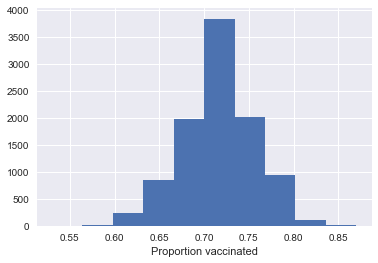

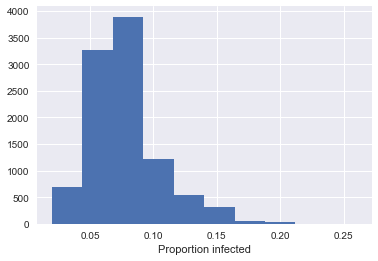

In [110]:
vacc_ba, inf_ba = simulate_plot_ba(p_si, p_ir, p_vacc, n, 4, 10000)

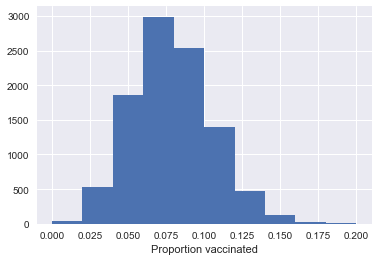

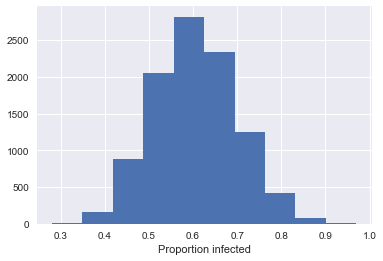

In [112]:
vacc_cycle, inf_cycle = simulate_plot_cycle(p_si, p_ir, p_vacc, n, 10000)

In [121]:
# vacc_complete, inf_complete = simulate_plot_complete(p_si, p_ir, p_vacc, n, 10000)

In [ ]:
vacc_path, inf_path = simulate_plot_path(p_si, p_ir, p_vacc, n, 10000)